In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd


In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
sys.path.append(os.path.abspath(".."))
from utils import read_features, read_targets, metrics_c, run_cv_all, update_scoreboard, plot_compare_feature_scores, d_types_methods, reduce_components, print_info_features, combine_features_all_txt_img, scale_feature_set, run_cv_all_2, subplots_c

## Read Features and Targets

In [4]:
path = os.path.abspath(os.path.join(os.getcwd(), "../../data/chronology_prediction"))

In [5]:
X = read_features(path)
y = read_targets(path, ["HistoricalPeriod"])

Loaded X_train_tfidf
Loaded X_train_bert
Loaded X_train_cannyhog
Loaded X_train_resnet
Loaded X_train_vit
Loaded X_test_tfidf
Loaded X_test_bert
Loaded X_test_cannyhog
Loaded X_test_resnet
Loaded X_test_vit
Loaded y_train
Loaded y_test


## Scale Features

In [6]:
X = {
    subset: {
        method: scale_feature_set(_X) if method != "tfidf" else _X
        for method, _X in X[subset].items()
    } for subset in X.keys()
}

## Reduce Features

Use n_components=0.95 to keep enough components to preserve 95% of the variance in the data.

In [7]:
reducers = {}
X_reduced = {subset: {} for subset in X.keys()}
for method in d_types_methods["text"] + d_types_methods["image"]:
    if method == "tfidf":
        for subset in X.keys(): X_reduced[subset][method] = X[subset][method]
        continue

    X_reduced["train"][method], reducers[method] = reduce_components(X["train"][method], n_components=0.95)

    X_reduced["test"][method], _ = reduce_components(X["test"][method], reducer_fitted=reducers[method])

In [8]:
print_info_features(X)

X = {
	train: {
		tfidf: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 300), 
		bert: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 768), 
		cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2917), 
		resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 2048), 
		vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (1719, 768), 
	},
	test: {
		tfidf: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (191, 300), 
		bert: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (191, 768), 
		cannyhog: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (191, 2917), 
		resnet: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (191, 2048), 
		vit: 
			<class 'pandas.core.frame.DataFrame'>
			shape = (191, 768), 
	},
}


## Combine & Re-scale Text & Image Feature Sets

In [9]:
for subset in X.keys():
    X[subset].update(combine_features_all_txt_img(X[subset], scale=True))
    X_reduced[subset].update(combine_features_all_txt_img(X_reduced[subset], scale=True))

## Encode Target Labels

In [10]:
le = LabelEncoder()

y["train"]["HistoricalPeriod_encoded"] = le.fit_transform(y["train"]["HistoricalPeriod"])
y["test"]["HistoricalPeriod_encoded"] = le.transform(y["test"]["HistoricalPeriod"])

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
for label, encoding in label_mapping.items():
    print(f"{encoding} --> {label}")

0 --> Archaic
1 --> Classical
2 --> Hellenistic
3 --> Orientalizing


## Load Best Parameters from HP Tuning

In [11]:
path_params = "best_params.json"
with open(path_params, "r") as f:
    best_params = json.load(f)
    best_params = {
        model: {
            eval(k): v for k, v in param_dict.items()
        } for model, param_dict in best_params.items()
    }

## Initialize 10-Fold Cross Validation


In [12]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
folds = list(skf.split(np.arange(y["train"].shape[0]), y["train"]["HistoricalPeriod_encoded"]))

## Initialize Scoreboard

In [13]:
scoreboard = pd.DataFrame(columns=["model", "target", "features"] + list(metrics_c.keys()))
scoreboard

,model,target,features,accuracy,precision,recall,f1


## Logistic Regression

Cross Validation Score Progression


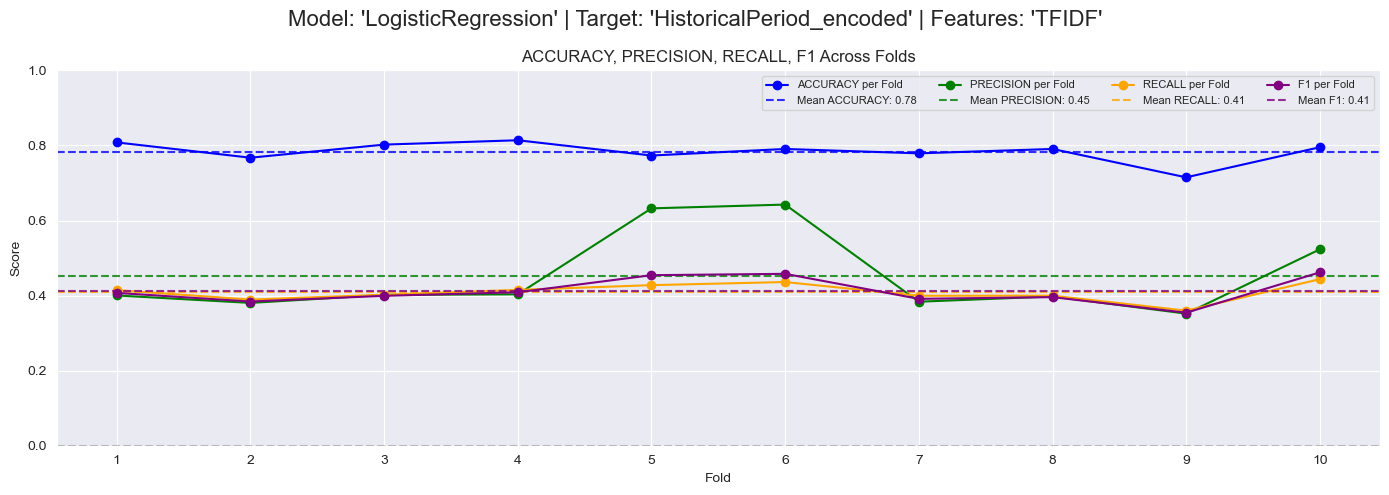

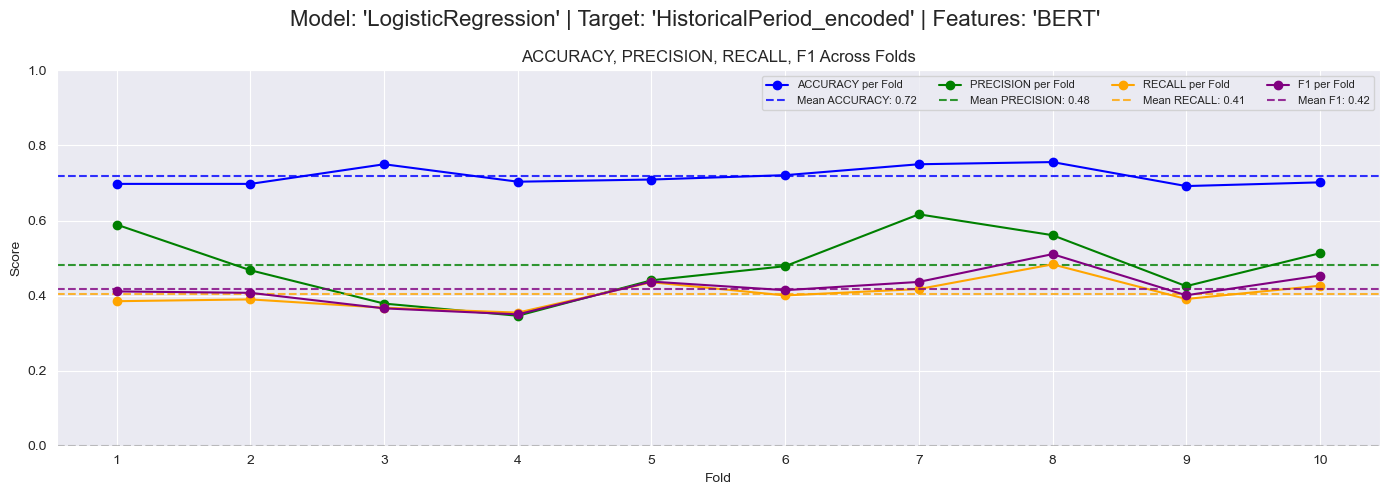

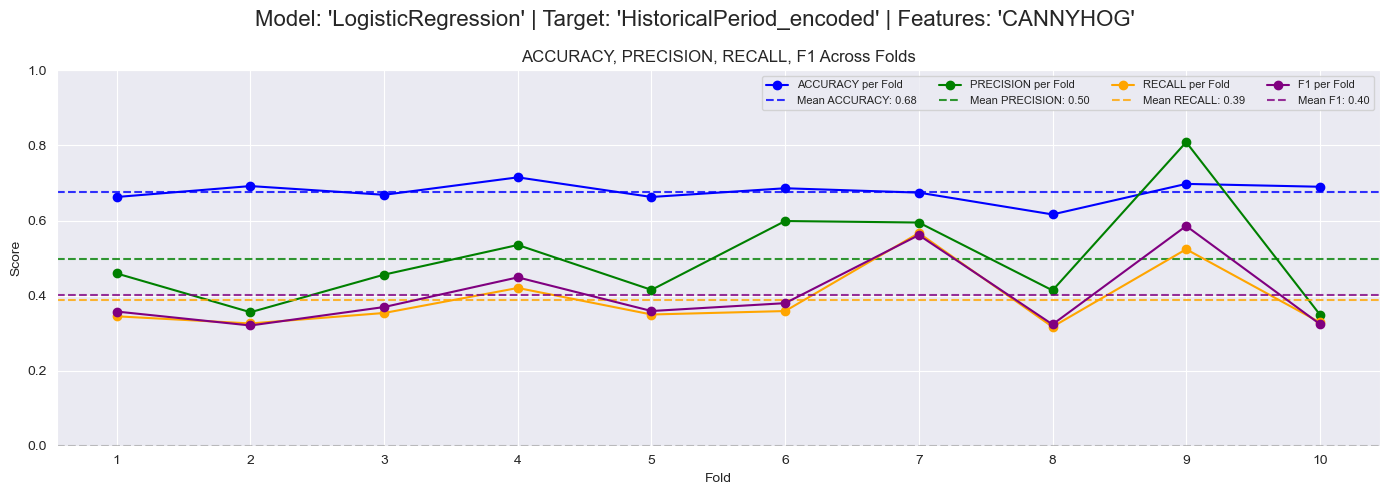

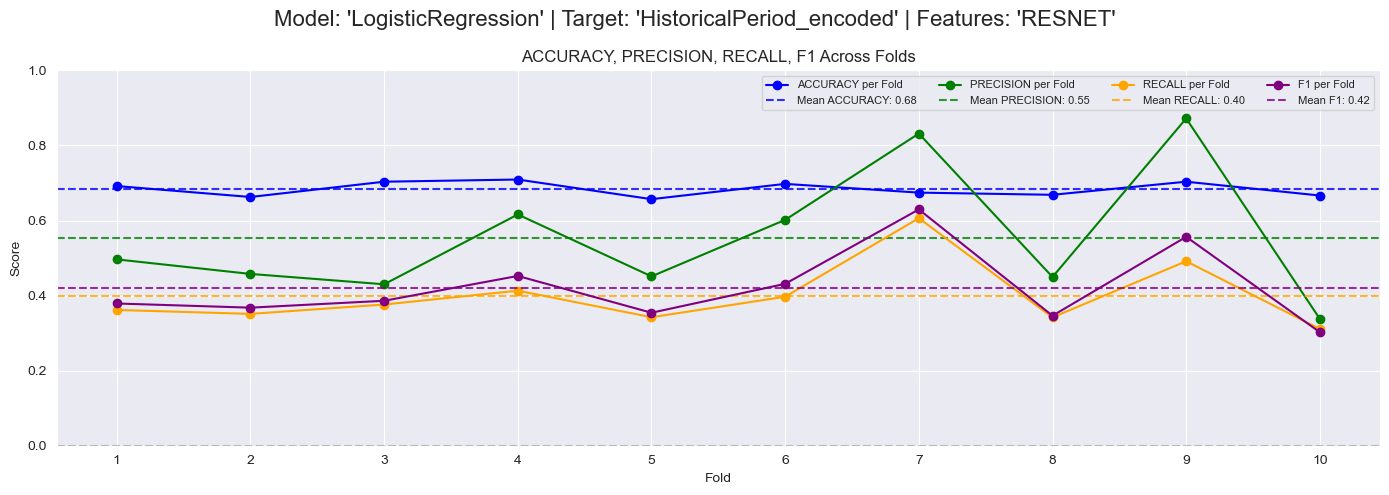

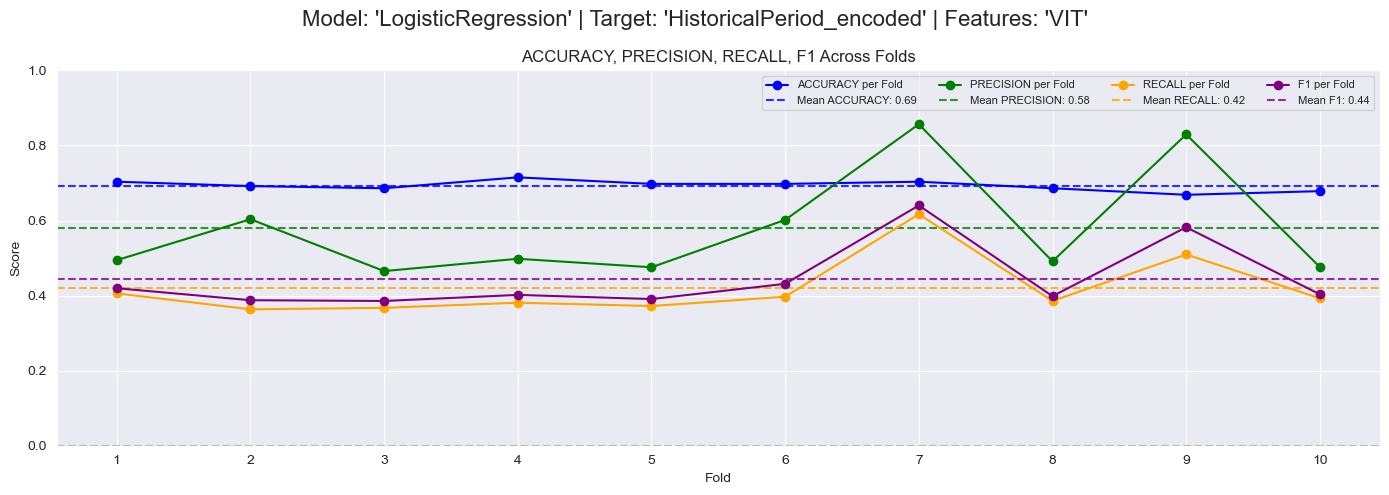

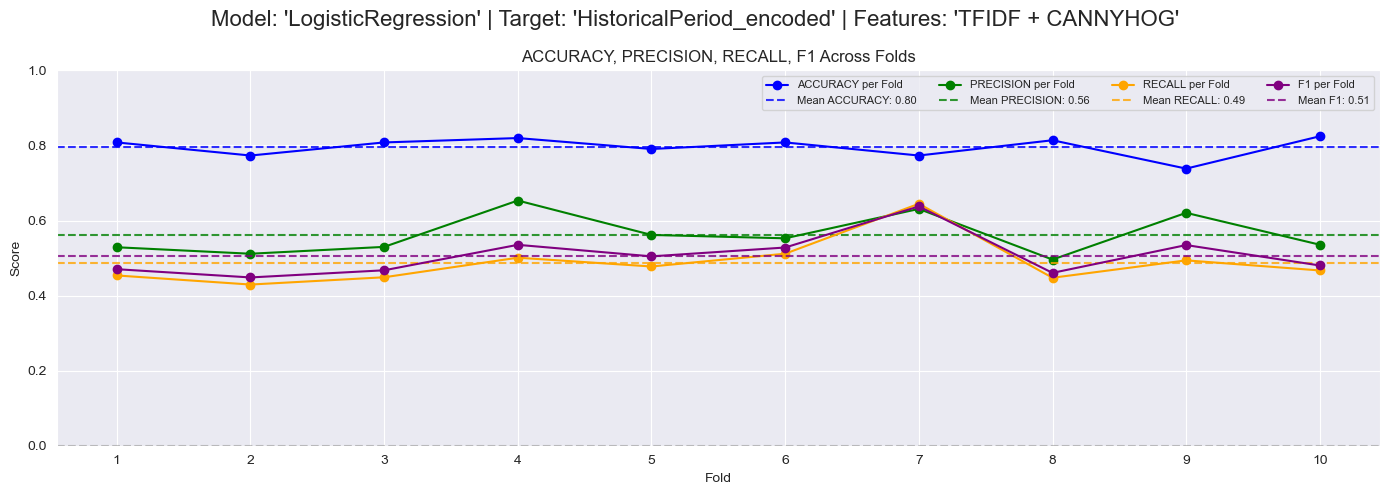

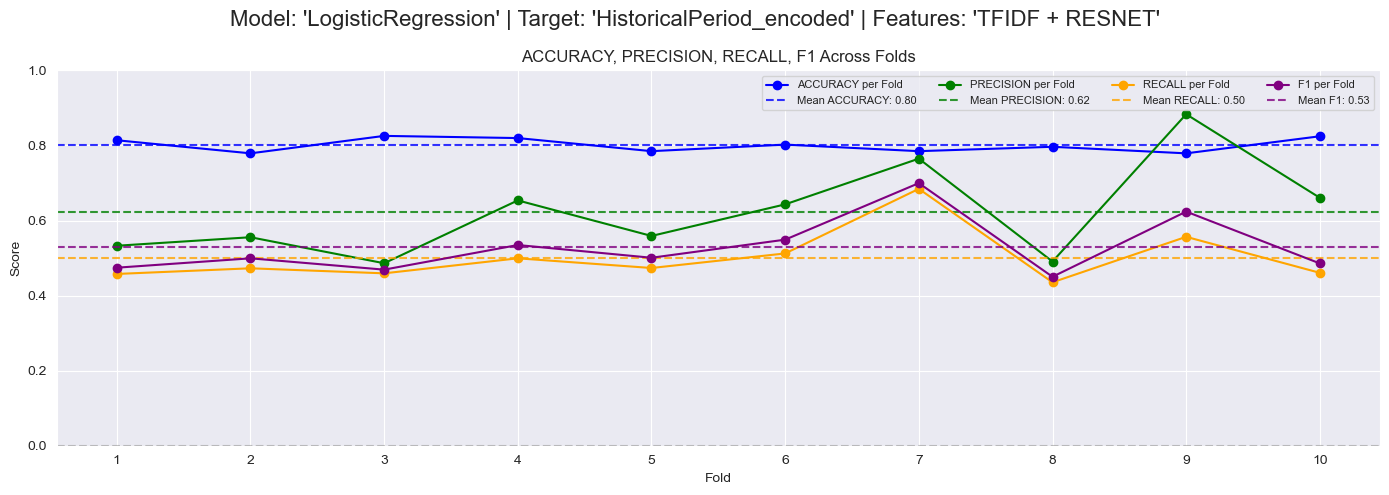

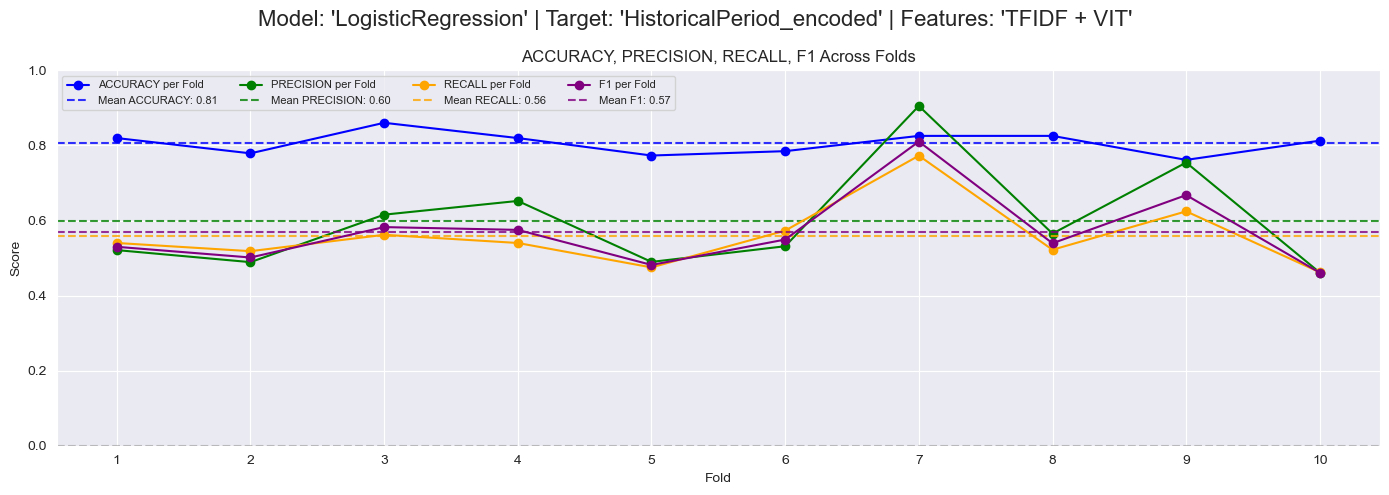

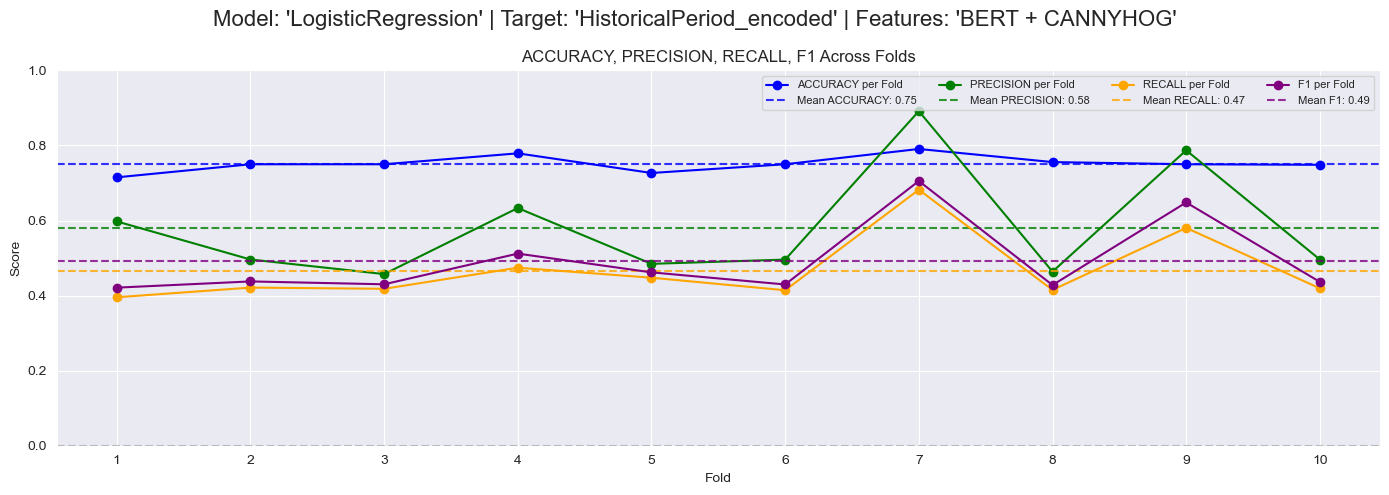

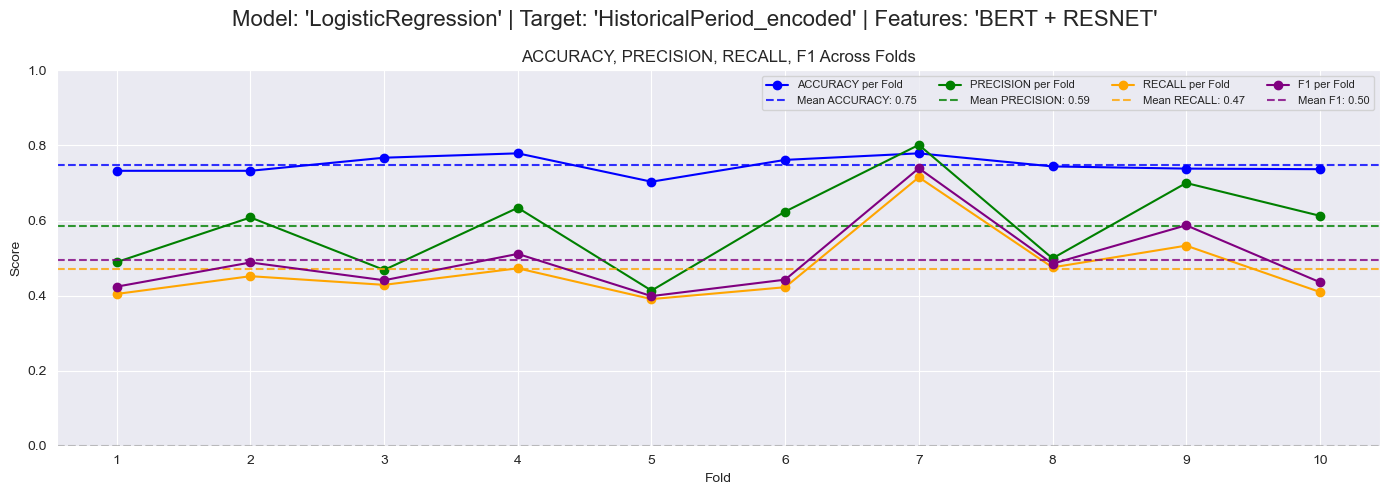

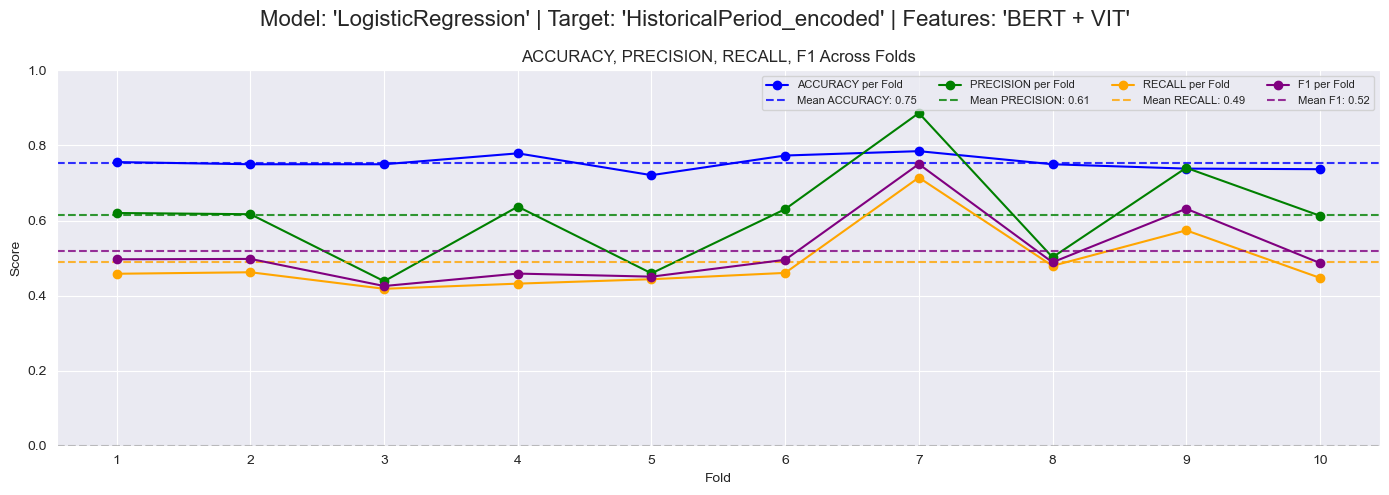

Compare Mean Cross Validation Scores of Feature Sets for One Model


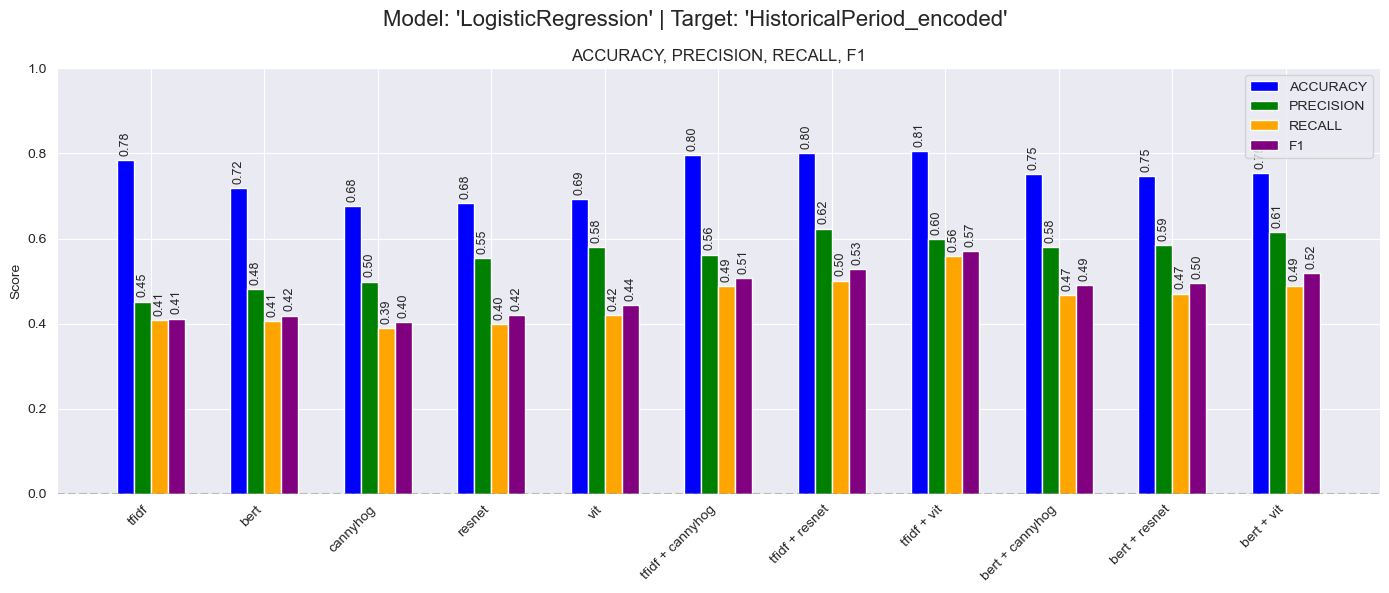

In [14]:
model_name = 'LogisticRegression'
model_class = LogisticRegression

model_scoreboard = run_cv_all_2(
    model_name,
    model_class,
    best_params[model_name],
    folds,
    metrics_c,
    X["train"],
    y["train"][["HistoricalPeriod_encoded"]]
)
plot_compare_feature_scores(model_scoreboard)
scoreboard = update_scoreboard(scoreboard, model_scoreboard)

## KNN

Compare Mean Cross Validation Scores of Feature Sets for One Model


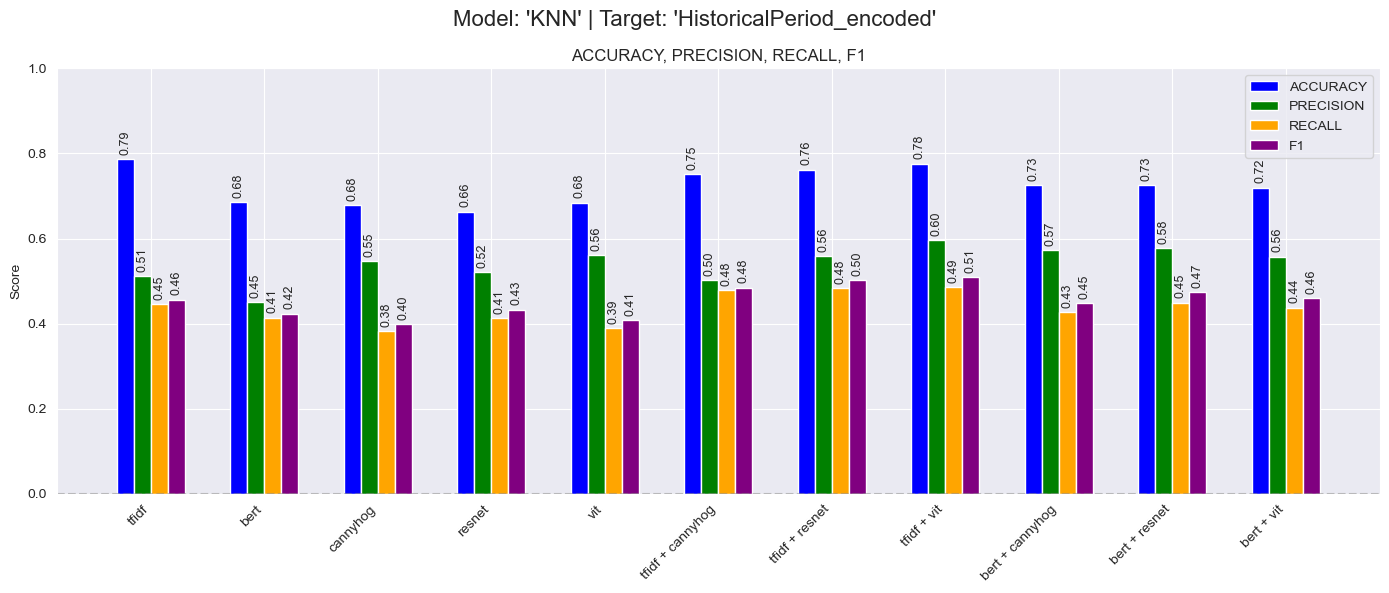

In [15]:
model_name = 'KNN'
model_class = KNeighborsClassifier

model_scoreboard = run_cv_all_2(
    model_name,
    model_class,
    best_params[model_name],
    folds,
    metrics_c,
    X["train"],
    y["train"][["HistoricalPeriod_encoded"]],
    enable_plots=False
)
plot_compare_feature_scores(model_scoreboard)
scoreboard = update_scoreboard(scoreboard, model_scoreboard)

## Random Forrest

Compare Mean Cross Validation Scores of Feature Sets for One Model


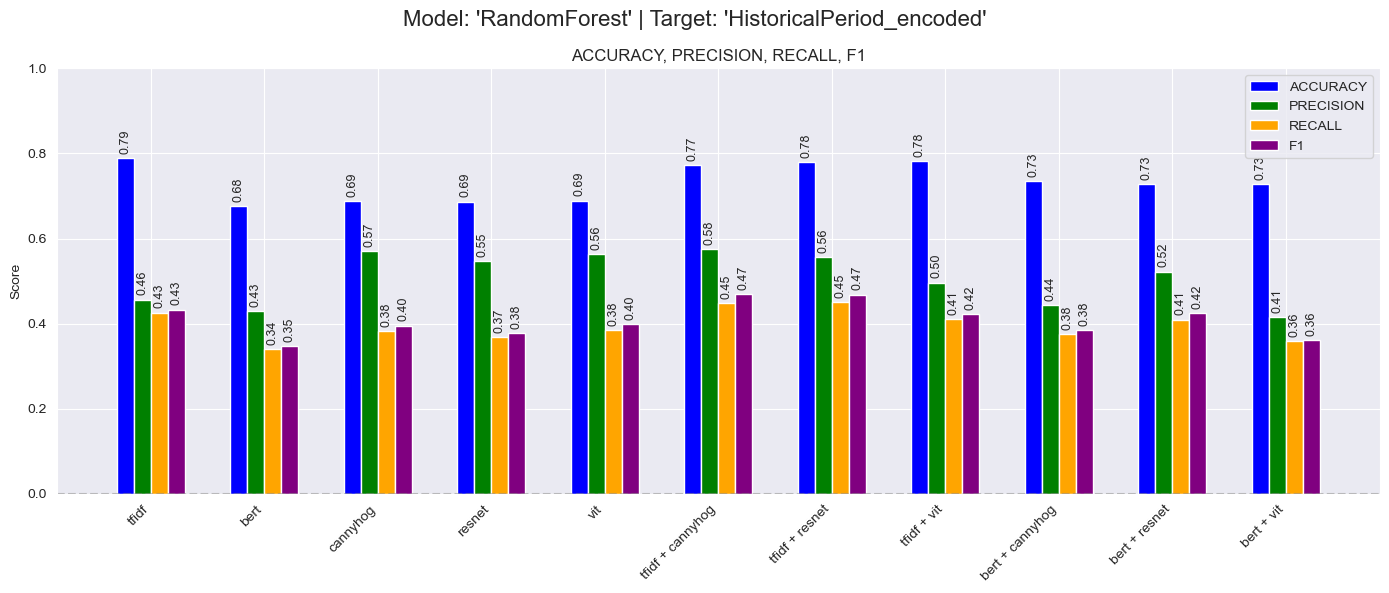

In [16]:
model_name = 'RandomForest'
model_class = RandomForestClassifier

model_scoreboard = run_cv_all_2(
    model_name,
    model_class,
    best_params[model_name],
    folds,
    metrics_c,
    X["train"],
    y["train"][["HistoricalPeriod_encoded"]],
    enable_plots=False
)
plot_compare_feature_scores(model_scoreboard)
scoreboard = update_scoreboard(scoreboard, model_scoreboard)

## XGBoost

C:\Users\dimit\.conda\envs\thesis\Lib\site-packages\xgboost\core.py:705: UserWarning: [10:57:10] WARNING: D:\bld\xgboost-split_1748292846627\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Compare Mean Cross Validation Scores of Feature Sets for One Model


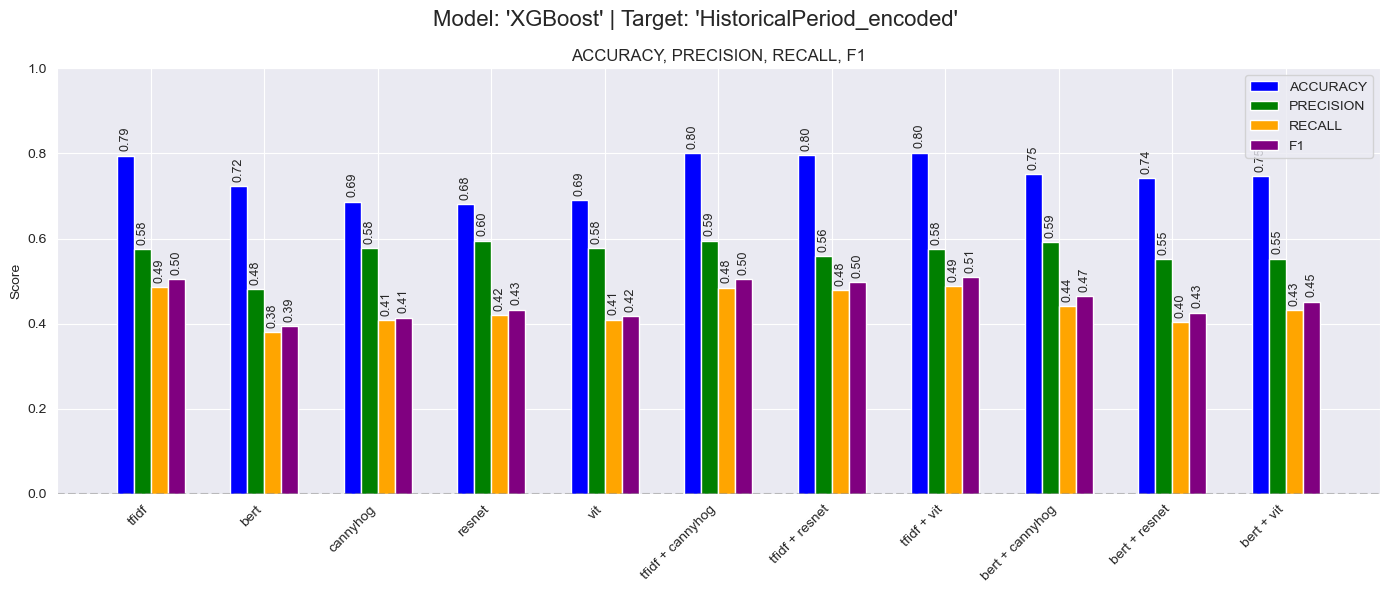

In [17]:
model_name = 'XGBoost'
model_class = XGBClassifier

model_scoreboard = run_cv_all_2(
    model_name,
    model_class,
    best_params[model_name],
    folds,
    metrics_c,
    X["train"],
    y["train"][["HistoricalPeriod_encoded"]],
    enable_plots=False
)
plot_compare_feature_scores(model_scoreboard)
scoreboard = update_scoreboard(scoreboard, model_scoreboard)

## LightGBM

Compare Mean Cross Validation Scores of Feature Sets for One Model


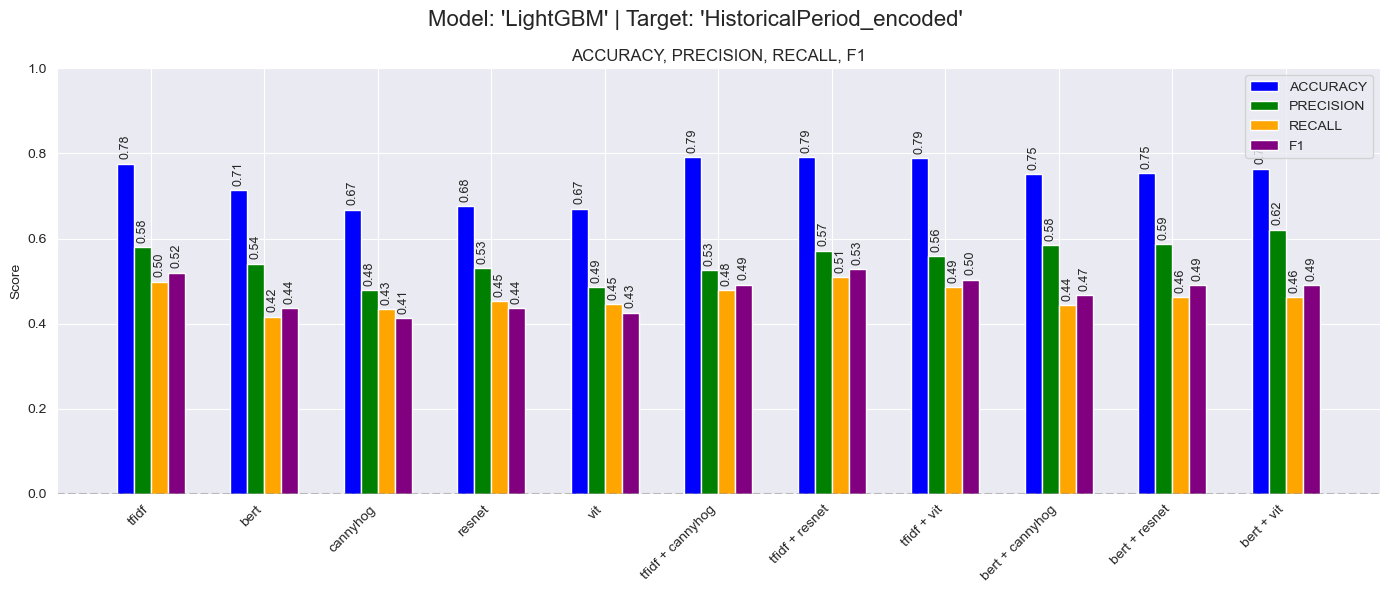

In [18]:
model_name = 'LightGBM'
model_class = LGBMClassifier

model_scoreboard = run_cv_all_2(
    model_name,
    model_class,
    best_params[model_name],
    folds,
    metrics_c,
    X["train"],
    y["train"][["HistoricalPeriod_encoded"]],
    enable_plots=False
)
plot_compare_feature_scores(model_scoreboard)
scoreboard = update_scoreboard(scoreboard, model_scoreboard)

## Final Scoreboard

In [19]:
scoreboard

,model,target,features,accuracy,precision,recall,f1
0,LogisticRegression,HistoricalPeriod_encoded,tfidf,0.783602,0.451795,0.408849,0.411579
1,LogisticRegression,HistoricalPeriod_encoded,bert,0.717850,0.481629,0.405132,0.418756
2,LogisticRegression,HistoricalPeriod_encoded,cannyhog,0.676564,0.498642,0.388886,0.402898
3,LogisticRegression,HistoricalPeriod_encoded,resnet,0.683527,0.554487,0.399265,0.420627
4,LogisticRegression,HistoricalPeriod_encoded,vit,0.692836,0.579237,0.419222,0.444136
5,LogisticRegression,HistoricalPeriod_encoded,tfidf + cannyhog,0.795828,0.562105,0.487536,0.506726
6,LogisticRegression,HistoricalPeriod_encoded,tfidf + resnet,0.801061,0.623000,0.501225,0.528703
7,LogisticRegression,HistoricalPeriod_encoded,tfidf + vit,0.806287,0.598600,0.559071,0.569892
8,LogisticRegression,HistoricalPeriod_encoded,bert + cannyhog,0.751598,0.580378,0.466843,0.491072
9,LogisticRegression,HistoricalPeriod_encoded,bert + resnet,0.747521,0.585085,0.470387,0.495277


In [20]:
scoreboard.to_csv(
    "cv_scoreboard.csv",
    index=False,
    encoding='utf-8',
    sep=',',
    header=True
)